In [1]:
from qiskit import pulse, circuit, transpile, assemble, schedule, IBMQ, QuantumCircuit, quantum_info as qi 
import qiskit
from qiskit.visualization import plot_gate_map, plot_error_map
from qiskit.visualization.pulse_v2 import draw
from qiskit.pulse import ShiftPhase, GaussianSquare, Drag, ControlChannel, MeasureChannel, DriveChannel, Play, Schedule
import numpy as np
from qiskit.tools import job_monitor
from copy import deepcopy
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [107]:
account_provider = IBMQ.load_account()
provider_opts = {'hub': 'ibm-q-ncsu', 'group': 'nc-state', 'project':'noiseanderror'}

# target backend
backend_name = 'ibmq_armonk'

provider = IBMQ.get_provider(**provider_opts)
backend = provider.get_backend(backend_name)

# backend information
config = backend.configuration()
defaults = backend.defaults()
properties = backend.properties()

# instruction schedule map
inst_map = defaults.instruction_schedule_map

ibmqfactory.load_account:WARNING:2021-11-21 15:29:19,194: Credentials are already in use. The existing account in the session will be replaced.


In [108]:
qubit = 0
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)

In [109]:
print(frequencies)

[4.95658557e+09 4.95718557e+09 4.95778557e+09 4.95838557e+09
 4.95898557e+09 4.95958557e+09 4.96018557e+09 4.96078557e+09
 4.96138557e+09 4.96198557e+09 4.96258557e+09 4.96318557e+09
 4.96378557e+09 4.96438557e+09 4.96498557e+09 4.96558557e+09
 4.96618557e+09 4.96678557e+09 4.96738557e+09 4.96798557e+09
 4.96858557e+09 4.96918557e+09 4.96978557e+09 4.97038557e+09
 4.97098557e+09 4.97158557e+09 4.97218557e+09 4.97278557e+09
 4.97338557e+09 4.97398557e+09 4.97458557e+09 4.97518557e+09
 4.97578557e+09 4.97638557e+09 4.97698557e+09 4.97758557e+09
 4.97818557e+09 4.97878557e+09 4.97938557e+09 4.97998557e+09
 4.98058557e+09 4.98118557e+09 4.98178557e+09 4.98238557e+09
 4.98298557e+09 4.98358557e+09 4.98418557e+09 4.98478557e+09
 4.98538557e+09 4.98598557e+09 4.98658557e+09]


In [110]:
def spectroscopy_scheds(qubit, pulse_params, backend):
    freq_param = circuit.Parameter("frequency")
    with pulse.build(backend=backend, name="spectroscopy") as schedule:
        pulse.shift_frequency(freq_param, DriveChannel(qubit))
        pulse.play(
            GaussianSquare(duration=pulse_params["duration"], 
                           amp = pulse_params["amp"], 
                           sigma=pulse_params["sigma"], 
                           width=pulse_params["width"]), DriveChannel(qubit))
        pulse.shift_frequency(-freq_param, DriveChannel(qubit))
        
    return schedule, freq_param

def template_circuit(freq_param):
    temp_circ = QuantumCircuit(1)
    temp_circ.append(circuit.Gate(name="Spec", num_qubits=1, params=[freq_param]), (0,))
    temp_circ.measure_active()
    return temp_circ

def spectroscopy_circuits(qubit, frequencies, pulse_params, backend):
    sched, freq_param = spectroscopy_scheds(qubit, pulse_params, backend)
    circuit = template_circuit(freq_param)
    circuit.add_calibration("Spec", (qubit,), sched, params=[freq_param])
    
    center_freq = backend.defaults().qubit_freq_est[qubit]
    
    circs = []
    for freq in frequencies:
        freq_shift = freq
        freq_shift -= center_freq
        freq_shift = np.round(freq_shift, decimals=3)
        assigned_circ = circuit.assign_parameters({freq_param: freq_shift}, inplace=False)
        circs.append(assigned_circ)
    return circs

In [111]:
pulse_params = {}

pulse_params["duration"] = 1024
pulse_params["amp"] = 0.1
pulse_params["sigma"] = 256
pulse_params["width"] = 0
schedules = spectroscopy_scheds(0, pulse_params, backend)

In [112]:
circs = spectroscopy_circuits(qubit, frequencies, pulse_params, backend)

In [113]:
transpiled_circs = transpile(circs, backend, initial_layout=[0])

In [114]:
transpiled_circs[0].draw()

┌─────────────────────────┐ ░ ┌─┐
  q_0 -> 0 ┤ Spec(-15000000.0000000) ├─░─┤M├
           └─────────────────────────┘ ░ └╥┘
measure: 1/═══════════════════════════════╩═
                                          0

In [115]:
job = backend.run(transpiled_circs, job_name="spectroscopy", shots=2048)
job_id = job.job_id()
print(job.job_id())

619aac3a53ac6ccf4ad59760


In [123]:
# 11/21/spectroscopy
# jakarta (11:51) 619a768168476d6e298a8394

# lagos (2:16) 619a9b38cd37f33609f2702d

# armonk (3:29) 619aac3a53ac6ccf4ad59760
backend = provider.get_backend("ibmq_armonk")
results = backend.retrieve_job("619aac3a53ac6ccf4ad59760").result()

In [124]:
print(results.get_counts())

[{'0': 1897, '1': 151}, {'0': 1873, '1': 175}, {'0': 1873, '1': 175}, {'0': 1879, '1': 169}, {'0': 1901, '1': 147}, {'0': 1877, '1': 171}, {'0': 1911, '1': 137}, {'0': 1874, '1': 174}, {'0': 1887, '1': 161}, {'0': 1900, '1': 148}, {'0': 1878, '1': 170}, {'0': 1901, '1': 147}, {'0': 1885, '1': 163}, {'0': 1865, '1': 183}, {'0': 1883, '1': 165}, {'0': 1860, '1': 188}, {'0': 1846, '1': 202}, {'0': 1797, '1': 251}, {'0': 1748, '1': 300}, {'0': 1660, '1': 388}, {'0': 1560, '1': 488}, {'0': 1446, '1': 602}, {'0': 1339, '1': 709}, {'0': 1267, '1': 781}, {'0': 1188, '1': 860}, {'0': 1163, '1': 885}, {'0': 1190, '1': 858}, {'0': 1239, '1': 809}, {'0': 1351, '1': 697}, {'0': 1450, '1': 598}, {'0': 1543, '1': 505}, {'0': 1653, '1': 395}, {'0': 1709, '1': 339}, {'0': 1758, '1': 290}, {'0': 1840, '1': 208}, {'0': 1842, '1': 206}, {'0': 1854, '1': 194}, {'0': 1884, '1': 164}, {'0': 1877, '1': 171}, {'0': 1879, '1': 169}, {'0': 1877, '1': 171}, {'0': 1901, '1': 147}, {'0': 1892, '1': 156}, {'0': 1889

In [125]:
import json
result_dict = results.to_dict()

result_dict["date"] = None
f = open("nov_21_armonk_spectroscopy_results.json", "w")
json.dump(result_dict, f)
f.close()

In [126]:
exp_vals = []
for counts in results.get_counts():
    exp_val = 0
    for k,v in counts.items():
        if k == "1":
            exp_val -= v
        else:
            exp_val += v
    exp_vals.append(exp_val)
print(exp_vals)

[1746, 1698, 1698, 1710, 1754, 1706, 1774, 1700, 1726, 1752, 1708, 1754, 1722, 1682, 1718, 1672, 1644, 1546, 1448, 1272, 1072, 844, 630, 486, 328, 278, 332, 430, 654, 852, 1038, 1258, 1370, 1468, 1632, 1636, 1660, 1720, 1706, 1710, 1706, 1754, 1736, 1730, 1730, 1690, 1742, 1764, 1728, 1736, 1718]


In [127]:
frequencies_GHz = frequencies*1e-9
print(frequencies_GHz)

[4.95658557 4.95718557 4.95778557 4.95838557 4.95898557 4.95958557
 4.96018557 4.96078557 4.96138557 4.96198557 4.96258557 4.96318557
 4.96378557 4.96438557 4.96498557 4.96558557 4.96618557 4.96678557
 4.96738557 4.96798557 4.96858557 4.96918557 4.96978557 4.97038557
 4.97098557 4.97158557 4.97218557 4.97278557 4.97338557 4.97398557
 4.97458557 4.97518557 4.97578557 4.97638557 4.97698557 4.97758557
 4.97818557 4.97878557 4.97938557 4.97998557 4.98058557 4.98118557
 4.98178557 4.98238557 4.98298557 4.98358557 4.98418557 4.98478557
 4.98538557 4.98598557 4.98658557]


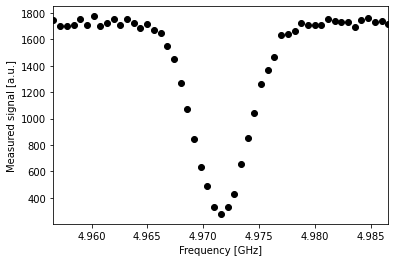

In [128]:
plt.scatter(frequencies_GHz, np.real(exp_vals), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

In [129]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

def _1gaussian(x, amp1,cen1,sigma1):
    return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

def simple_gaussian(x, A, B):
    y = A*np.exp(-1*B*x**2)
    return y

In [130]:
import scipy
popt_gauss, pcov_gauss = scipy.optimize.curve_fit(_1gaussian, frequencies_GHz, exp_vals)
perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [131]:
print(popt_gauss)

[ 6.34695337e+04 -4.73739875e+00  7.36899013e+00]


In [104]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(exp_vals), 
                                 lambda x, A, q_freq, B, C: (A / np.pi) * (B / ((x - q_freq)**2 + B**2)) + C, [5, 5.2, 1, 3]
)

In [105]:
print(fit_params)

[-686.04595619 9107.50948175 1068.69889984  935.47901392]


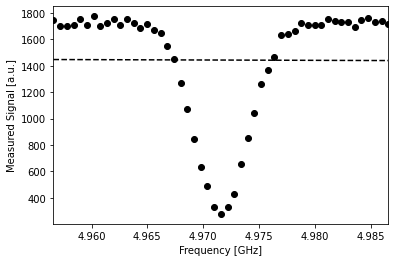

In [135]:
plt.scatter(frequencies_GHz, np.real(exp_vals), color='black')
# plt.plot(frequencies, simple_gaussian(frequencies, *popt_gauss), color="red")
plt.plot(frequencies_GHz, _1gaussian(frequencies_GHz, *popt_gauss), 'k--')
# plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()